In [ ]:
# import clear out to clear output during library installation
from IPython.display import clear_output
!pip install transformers datasets torch scikit-learn seaborn

In [ ]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


Using device: cuda
GPU: NVIDIA L4


# The IMDb movie reviews dataset is used for this study. It consists of 50,000 English-language movie reviews evenly split between positive and negative sentiment labels. The dataset is pre-divided into training and testing subsets.


In [ ]:
dataset = load_dataset("imdb")

dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

This cell extracts a small set of example reviews from the training dataset for demonstration purposes. It collects three positive and three negative reviews based on their sentiment labels. For each selected review, the code displays the dataset index, sentiment label, and a truncated version of the review text (up to 600 characters) to provide a quick preview of the content. This helps in understanding the type of data and the sentiment distribution in the dataset before further processing.

In [ ]:
positive_reviews = []
negative_reviews = []

# Collect 3 unique reviews per class
for idx, review in enumerate(dataset["train"]):
    if review["label"] == 1 and len(positive_reviews) < 3:
        positive_reviews.append((idx, review["text"], review["label"]))
    elif review["label"] == 0 and len(negative_reviews) < 3:
        negative_reviews.append((idx, review["text"], review["label"]))

    if len(positive_reviews) == 3 and len(negative_reviews) == 3:
        break

# Display positive reviews
print("POSITIVE REVIEWS")
print("=" * 90)
for i, (idx, text, label) in enumerate(positive_reviews, 1):
    print(f"Positive Review {i}")
    print(f"Dataset Index: {idx}")
    print(f"Sentiment Label: {label} (Positive)")
    print(text[:600])
    print("-" * 90)

# Display negative reviews
print("\nNEGATIVE REVIEWS")
print("=" * 90)
for i, (idx, text, label) in enumerate(negative_reviews, 1):
    print(f"Negative Review {i}")
    print(f"Dataset Index: {idx}")
    print(f"Sentiment Label: {label} (Negative)")
    print(text[:600])
    print("-" * 90)



POSITIVE REVIEWS
Positive Review 1
Dataset Index: 12500
Sentiment Label: 1 (Positive)
Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This 
------------------------------------------------------------------------------------------
Positive Review 2
Dataset Index: 12501
Sentiment Label: 1 (Positive)
Zentropa is the most original movie I've seen in years. If you like unique thrillers that are influenced by film noir, then this is just the right cure f

This cell visualizes the distribution of sentiment labels in the IMDb training dataset. It counts the number of positive and negative reviews, then creates a bar chart to show how many reviews belong to each class. The chart also displays the exact count above each bar for clarity, helping to quickly understand the dataset’s class balance.

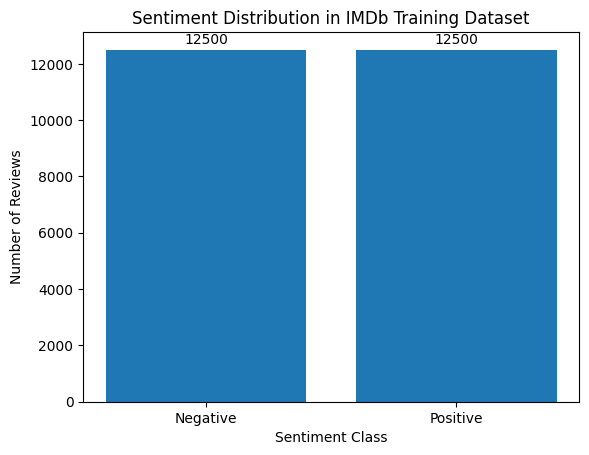

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Count sentiment labels
label_counts = Counter(dataset["train"]["label"])

sentiments = ["Negative", "Positive"]
counts = [label_counts[0], label_counts[1]]

plt.figure()
plt.bar(sentiments, counts)
plt.xlabel("Sentiment Class")
plt.ylabel("Number of Reviews")
plt.title("Sentiment Distribution in IMDb Training Dataset")

# Add numbers on top of bars
for i, count in enumerate(counts):
    plt.text(i, count + 200, str(count), ha="center")

plt.show()


This cell prepares the dataset for BERT by tokenizing the text. It loads a pre-trained BERT tokenizer and defines a function to convert each review into token IDs, applying padding and truncation to ensure a uniform length of 256 tokens. The dataset is then processed in batches to produce a tokenized version suitable for input to a BERT model.

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

This cell finalizes the tokenized dataset for PyTorch model training. It removes the original text column, renames the label column to “labels” to match BERT’s expected input format, and sets the dataset to return PyTorch tensors, making it ready for direct use in model training and evaluation.

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")


This cell loads a pre-trained BERT model for sequence classification. It initializes the model with two output labels to perform binary sentiment classification (positive vs. negative) using the “bert-base-uncased” architecture.

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


function to calculate accuracy, precision, recall, and F1-score for evaluating the model’s predictions.

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


sets up training configurations for BERT, including learning rate, batch size, number of epochs, evaluation and saving strategies, weight decay, logging, and loading the best model at the end.

In [ ]:
training_args = TrainingArguments(
    output_dir="./bert_sentiment",
    eval_strategy="epoch",
    save_strategy="epoch", # Added to match eval_strategy
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/tmp/ipython-input-4169131945.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.247400,0.226725,0.910000,0.948538,0.867040,0.905960
2,0.161500,0.254096,0.917560,0.929200,0.904000,0.916427
3,0.092100,0.358134,0.918960,0.922611,0.914640,0.918608
4,0.040800,0.413884,0.920400,0.903548,0.941280,0.922028
5,0.027300,0.448008,0.922320,0.922455,0.922160,0.922308


TrainOutput(global_step=7815, training_loss=0.1190156405809516, metrics={'train_runtime': 3279.8722, 'train_samples_per_second': 38.111, 'train_steps_per_second': 2.383, 'total_flos': 1.644444096e+16, 'train_loss': 0.1190156405809516, 'epoch': 5.0})

Predictions are generated on the test set, a confusion matrix is computed from the true and predicted labels, and it is visualized to show how well the model distinguishes between positive and negative reviews.

<Figure size 600x500 with 0 Axes>

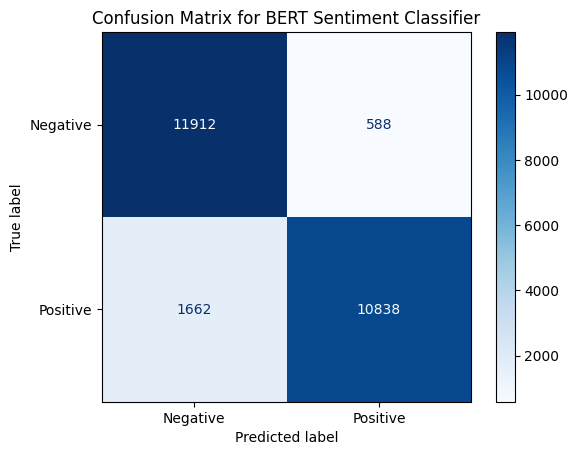

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions on test set
predictions = trainer.predict(tokenized_datasets["test"])

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Negative", "Positive"]
)

plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for BERT Sentiment Classifier")
plt.show()


Training and validation losses are tracked over epochs and plotted to visualize how the model’s performance evolves during training.

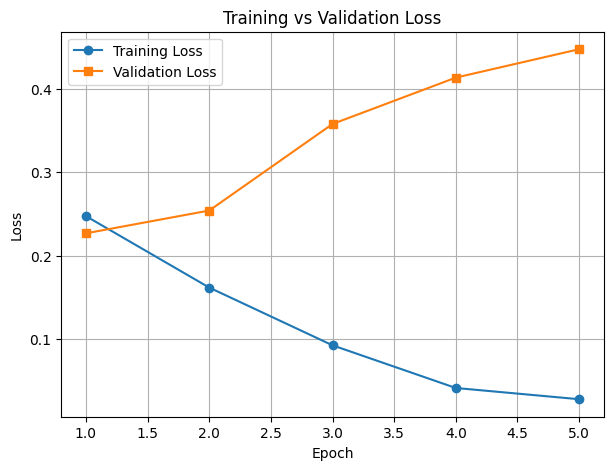

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
eval_losses = []
epochs = []

current_epoch = 0
last_train_loss = None

for log in trainer.state.log_history:
    # Track training loss
    if "loss" in log and "epoch" in log:
        last_train_loss = log["loss"]

    # Track evaluation loss (end of epoch)
    if "eval_loss" in log:
        current_epoch += 1
        epochs.append(current_epoch)
        eval_losses.append(log["eval_loss"])
        train_losses.append(last_train_loss)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses, marker="o", label="Training Loss")
plt.plot(epochs, eval_losses, marker="s", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


# This prepares a baseline model using Logistic Regression with TF-IDF features, providing a simple reference point before applying BERT for sentiment classification.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Extract raw text and labels
X_train = dataset["train"]["text"]
y_train = dataset["train"]["label"]

X_test = dataset["test"]["text"]
y_test = dataset["test"]["label"]

# TF-IDF Vectorisation
tfidf = TfidfVectorizer(
    max_features=10000,
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


A simple Logistic Regression model is trained on the TF-IDF features of the training data and used to predict sentiment labels on the test set.

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test_tfidf)


The performance of the Logistic Regression baseline is evaluated on the test set, calculating accuracy, precision, recall, and F1-score to assess how well it predicts sentiment.

In [ ]:
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision, lr_recall, lr_f1, _ = precision_recall_fscore_support(
    y_test, y_pred_lr, average="binary"
)

print("Logistic Regression Performance:")
print(f"Accuracy:  {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall:    {lr_recall:.4f}")
print(f"F1-score:  {lr_f1:.4f}")


Logistic Regression Performance:
Accuracy:  0.8804
Precision: 0.8793
Recall:    0.8818
F1-score:  0.8805


A confusion matrix is computed and visualized to show how well the Logistic Regression baseline distinguishes between positive and negative reviews.

<Figure size 600x500 with 0 Axes>

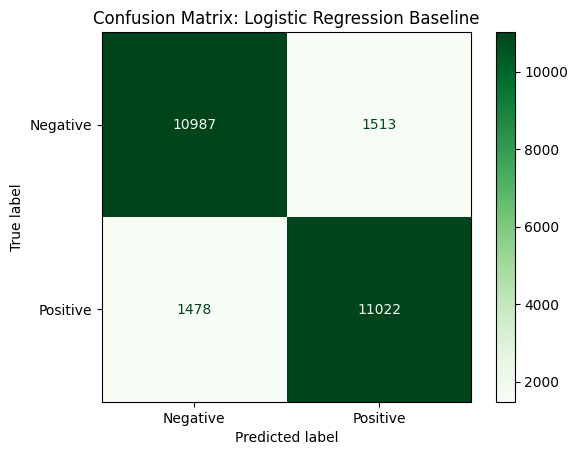

In [ ]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

disp_lr = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=["Negative", "Positive"]
)

plt.figure(figsize=(6, 5))
disp_lr.plot(cmap="Greens")
plt.title("Confusion Matrix: Logistic Regression Baseline")
plt.show()


Evaluation metrics from both the Logistic Regression baseline and the fine-tuned BERT model are collected and presented in a table for easy comparison of their performance.

In [ ]:
# Get BERT evaluation metrics
bert_metrics = trainer.evaluate()

comparison_results = {
    "Model": ["Logistic Regression", "Fine-tuned BERT"],
    "Accuracy": [lr_accuracy, bert_metrics["eval_accuracy"]],
    "Precision": [lr_precision, bert_metrics["eval_precision"]],
    "Recall": [lr_recall, bert_metrics["eval_recall"]],
    "F1-score": [lr_f1, bert_metrics["eval_f1"]],
}

import pandas as pd

comparison_df = pd.DataFrame(comparison_results)
comparison_df


,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.88036,0.879298,0.88176,0.880527
1,Fine-tuned BERT,0.91000,0.948538,0.86704,0.905960


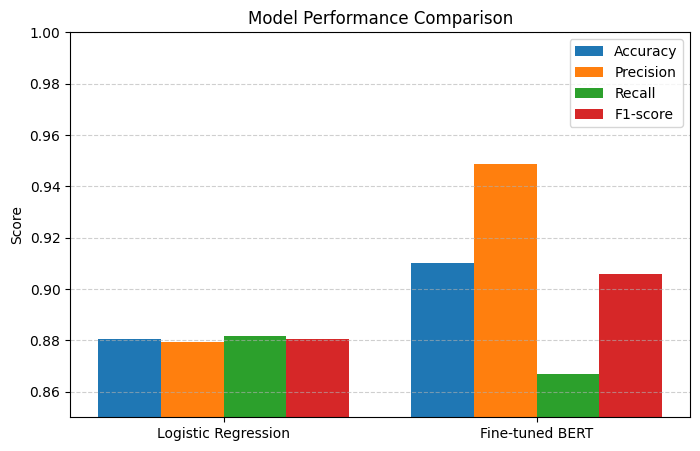

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
models = ["Logistic Regression", "Fine-tuned BERT"]
accuracy = [0.88036, 0.91000]
precision = [0.879298, 0.948538]
recall = [0.88176, 0.86704]
f1 = [0.880527, 0.905960]

# X positions
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(8, 5))

plt.bar(x - 1.5*width, accuracy, width, label="Accuracy")
plt.bar(x - 0.5*width, precision, width, label="Precision")
plt.bar(x + 0.5*width, recall, width, label="Recall")
plt.bar(x + 1.5*width, f1, width, label="F1-score")

plt.xticks(x, models)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.ylim(0.85, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()


A bar chart is created to visually compare the accuracy of the Logistic Regression baseline and the fine-tuned BERT model, highlighting the performance improvement with BERT.

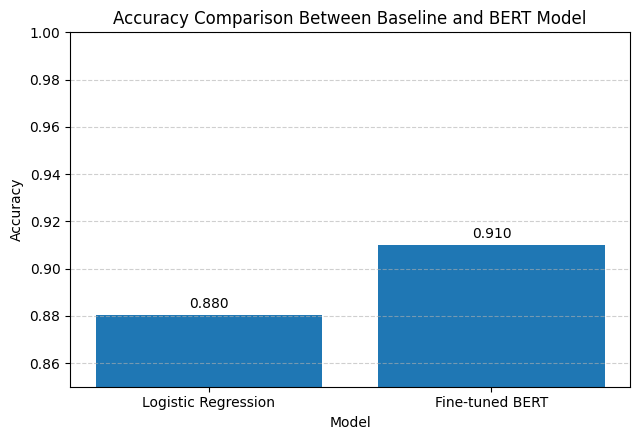

In [ ]:
import matplotlib.pyplot as plt

models = ["Logistic Regression", "Fine-tuned BERT"]
accuracy = [0.88036, 0.91000]

fig, ax = plt.subplots(figsize=(6.5, 4.5))

bars = ax.bar(models, accuracy)

ax.set_ylabel("Accuracy")
ax.set_xlabel("Model")
ax.set_title("Accuracy Comparison Between Baseline and BERT Model")
ax.set_ylim(0.85, 1.0)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f"{height:.3f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=10
    )

ax.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


# Extra Naïve Bayes Performance

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

y_pred_nb = nb.predict(X_test_tfidf)

nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_precision, nb_recall, nb_f1, _ = precision_recall_fscore_support(
    y_test, y_pred_nb, average="binary"
)

print("Naïve Bayes Performance:")
print(f"Accuracy:  {nb_accuracy:.4f}")
print(f"Precision: {nb_precision:.4f}")
print(f"Recall:    {nb_recall:.4f}")
print(f"F1-score:  {nb_f1:.4f}")


Naïve Bayes Performance:
Accuracy:  0.8342
Precision: 0.8605
Recall:    0.7977
F1-score:  0.8279
